## Imports


In [1]:
import os

os.environ["PYSYN_CDBS"] = "/Users/peter/Downloads/grp/redcat/trds/"

In [2]:
import pandas as pd
import numpy as np
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt

import pysynphot as S  # you need BT Settl models installed.

import os
from glob import glob

/opt/homebrew/Caskroom/miniconda/base/envs/pysynphot/lib/python3.11/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/peter/Downloads/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/opt/homebrew/Caskroom/miniconda/base/envs/pysynphot/lib/python3.11/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/peter/Downloads/grp/redcat/trds/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/opt/homebrew/Caskroom/miniconda/base/envs/pysynphot/lib/python3.11/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/peter/Downloads/grp/redcat/trds/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


## Datafiles


In [45]:
# wavelengths = np.arange(0.3, 3, 0.0001)
wavelengths = np.arange(0.3, 3, 0.001)

R_sun = 6.957e8 * 1e2  # cm
M_sun = 1.9885e30 * 1e3  # g
G = 6.67408e-11 * 1e2**3 * 1e3**-1  # m3 kg-1 s-2

stellarProps = pd.read_csv("./datafiles/stellar_props_rochester.csv")
stellarProps = stellarProps[stellarProps["Msun"].isna() == False]
stellarProps["logg"] = np.log10(
    G * M_sun * stellarProps["Msun"] / (R_sun * stellarProps["R_Rsun"]) ** 2
)
df_spt = stellarProps.reindex(index=stellarProps.index[::-1]).reset_index(drop="index")

In [49]:
df_spt

,#SpT,Teff,logT,logL,Mbol,BCv,Mv,B-V,Bt-Vt,G-V,...,W1-W3,W1-W4,M_J,M_Ks,i-z,z-Y,R_Rsun,Msun,#SpT.1,logg
0,L2V,2000,3.292,-3.84,14.34,-6.56,20.90,NaN,NaN,NaN,...,NaN,NaN,12.34,10.90,2.04,0.90,0.104,0.075,L2V,5.279068
1,L1V,2100,3.322,-3.70,13.99,-6.51,20.50,NaN,NaN,NaN,...,NaN,NaN,12.14,10.80,2.02,0.88,0.107,0.076,L1V,5.260119
2,L0V,2250,3.352,-3.57,13.67,-6.33,20.00,NaN,NaN,-3.2,...,NaN,NaN,11.84,10.55,2.01,0.86,0.108,0.077,L0V,5.257716
3,M9.5V,2320,3.365,-3.55,13.62,-6.13,19.75,NaN,NaN,-3.1,...,NaN,NaN,11.78,10.45,2.00,0.84,0.104,0.078,M9.5V,5.296101
4,M9V,2400,3.380,-3.57,13.67,-5.90,19.36,NaN,NaN,-3.0,...,NaN,NaN,11.53,10.30,1.99,0.82,0.095,0.079,M9V,5.380253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,O9V,32500,4.512,4.82,-7.29,-3.09,-4.20,-0.318,NaN,NaN,...,NaN,NaN,-3.44,-3.20,NaN,NaN,8.110,19.700,O9V,3.914498
87,O8.5V,33000,4.519,4.87,-7.43,-3.13,-4.30,-0.320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.330,20.500,O8.5V,3.908537
88,O8V,34500,4.538,4.99,-7.72,-3.22,-4.50,-0.320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.750,22.900,O8V,3.913892
89,O7.5V,35000,4.544,5.05,-7.87,-3.27,-4.60,-0.320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.110,24.000,O7.5V,3.899247


## Definitions


In [50]:
def interpolate_dfs(index: list, *data: pd.DataFrame) -> pd.DataFrame:
    """
    Interpolates multiple pandas DataFrames based on a given index.

    Parameters:
    index (list): A list of index values to interpolate over.
    *data (pd.DataFrame): Variable number of pandas DataFrames to be interpolated.

    Returns:
    pd.DataFrame: A single DataFrame with interpolated values for the given index.
    """

    df = pd.DataFrame({"tmp": index}, index=index)
    for dat in data:
        dat = dat[~dat.index.duplicated(keep="first")]
        df = pd.concat([df, dat], axis=1)
    df = df.sort_index()
    df = df.interpolate("index").reindex(index)
    df.drop("tmp", axis=1, inplace=True)

    return df

## Code


In [ ]:
metallicity = 0
for k, star in df_spt.iterrows():
    temperature = star["Teff"]
    logg = star["logg"]

    phoenix = S.Icat("phoenix", temperature, metallicity, logg)
    phoenix.convert("Flam")  # [erg/s/cm^2/A]
    phoenix.convert("Micron")

    # star in [J/s/m^2/μm]
    phoenix_star = pd.DataFrame(
        {"phoenix_flux": phoenix.flux * 1e-7 * 1e4 * 1e4}, index=phoenix.wave
    )
    df = interpolate_dfs(wavelengths, phoenix_star)
    df.to_csv("./datafiles/stellar_spectra/" + str(temperature) + "K" + ".csv")

In [ ]:
pwv_values = np.array(
    [0.05, 0.1, 0.25, 0.5, 1.0, 1.5, 2.5, 3.5, 5.0, 7.5, 10.0, 20.0, 30.0]
)
airmass_values = np.array(
    [
        1.0,
        1.1,
        1.2,
        1.3,
        1.4,
        1.5,
        1.6,
        1.7,
        1.8,
        1.9,
        2.0,
        2.1,
        2.2,
        2.3,
        2.4,
        2.5,
        2.6,
        2.7,
        2.8,
        2.9,
        3.0,
    ]
)

for pwv in pwv_values:
    for airmass in airmass_values:
        hdulist = pyfits.open(
            "./datafiles/atmospheres_2400m/atm_"
            + str(pwv)
            + "_"
            + str(airmass)
            + ".fits"
        )
        sky_df = pd.DataFrame(
            {"sky_flux": hdulist[1].data["flux"].byteswap().newbyteorder()},
            index=hdulist[1].data["lam"] / 1000,
        )

        df = interpolate_dfs(wavelengths, sky_df)
        df.to_csv(
            "./datafiles/atmospheres_2400m/csv/radiance/"
            + str(pwv)
            + "_"
            + str(airmass)
            + ".csv"
        )

        sky_df = pd.DataFrame(
            {"sky_transmission": hdulist[1].data["trans"].byteswap().newbyteorder()},
            index=hdulist[1].data["lam"] / 1000,
        )
        df = interpolate_dfs(wavelengths, sky_df)
        df.to_csv(
            "./datafiles/atmospheres_2400m/csv/flux/"
            + str(pwv)
            + "_"
            + str(airmass)
            + ".csv"
        )

In [54]:
## below 2000 K stars

ATMO2020_files = glob(
    "./datafiles/stellar_spectra/ATMO_2020_models/CEQ_spectra/*lg5.5*"
)
temps = []
for file in ATMO2020_files:
    temps.append(int(file.split("/")[-1].split("_")[1][1:]))
temps.sort()

ATMO2020_stars = pd.read_csv(
    "./datafiles/stellar_props_rochester_20210302.csv", index_col="Teff"
)[
    ["R_Rsun"]
]  # Version 2021.03.02
ATMO2020_stars = interpolate_dfs(
    temps, ATMO2020_stars
)  # To get radius values to match temp values of ATMO_2020_models

In [ ]:
sky_type = "flux"
# sky_type = "radiance"


df = pd.DataFrame({}, index=wavelengths)

rootdir = "./datafiles/atmospheres_2400m/csv/" + sky_type + "/"

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if str(file[-4:]) == ".csv":
            df[str(file[:-4])] = pd.read_csv(rootdir + str(file), index_col=0)


Rsun = 6.96342e8  # [m]
h = 6.62607004e-34
c = 299792458
rootdir = "./datafiles/stellar_spectra/"
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if str(file[-4:]) == ".csv":
            R = (
                stellarProps[stellarProps["Teff"] == int(str(file[:-5]))][
                    "R_Rsun"
                ].values
                * Rsun
            )
            df[str(file[:-4])] = pd.read_csv(rootdir + str(file), index_col=0).apply(
                lambda x: x * R**2 * (x.index * 1e-6) / (h * c)
            )  # photon/s/m2/um

for file in ATMO2020_files:
    temp = int(file.split("/")[-1].split("_")[1][1:])
    if (temp > 400) and (temp < 1900):
        R = ATMO2020_stars.loc[int(temp)]["R_Rsun"] * Rsun
        star = pd.read_csv(
            file, delim_whitespace=True, skiprows=[0, 1], header=None, index_col=0
        ).apply(
            lambda x: x * R**2 * (x.index * 1e-6) / (h * c)
        )  # photon/s/m2/um
        df[str(temp) + "K"] = star = interpolate_dfs(wavelengths, star)

display(df)

/var/folders/_h/5qqvnwb96k93d4dkl5yccp3c0000gn/T/ipykernel_21656/3185322256.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(file[:-4])] = pd.read_csv(rootdir + str(file), index_col=0)
/var/folders/_h/5qqvnwb96k93d4dkl5yccp3c0000gn/T/ipykernel_21656/3185322256.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(file[:-4])] = pd.read_csv(rootdir + str(file), index_col=0)
/var/folders/_h/5qqvnwb96k93d4dkl5yccp3c0000gn/T/ipykernel_21656/3185322256.py:11: PerformanceWarning: DataFrame is highly fragmented.  This i

,7.5_1.9,0.1_2.7,0.25_1.6,1.0_1.3,10.0_1.9,30.0_2.9,20.0_1.7,3.5_2.7,2.5_1.6,2.5_1.7,...,800K,1300K,1600K,500K,450K,1100K,550K,1000K,1700K,1800K
0.300,0.001609,0.000108,0.004439,0.012256,0.001609,0.000055,0.003165,0.000108,0.004439,0.003165,...,3.930112e+30,3.764211e+31,6.279761e+31,2.433585e+28,4.330286e+27,2.124529e+31,9.589286e+28,1.390045e+31,8.340524e+31,9.623457e+31
0.301,0.002921,0.000255,0.007321,0.018371,0.002921,0.000139,0.005389,0.000255,0.007321,0.005389,...,6.200622e+30,3.426133e+31,5.451076e+31,6.156317e+28,8.607286e+27,2.145021e+31,2.806346e+29,1.529672e+31,7.093915e+31,8.023390e+31
0.302,0.004737,0.000501,0.011023,0.025663,0.004737,0.000287,0.008318,0.000501,0.011023,0.008318,...,1.309001e+30,6.195968e+30,1.124003e+31,4.330790e+28,8.721632e+27,4.235581e+30,1.264364e+29,3.233047e+30,1.431798e+31,1.554015e+31
0.303,0.008450,0.001144,0.017932,0.038082,0.008450,0.000696,0.013953,0.001144,0.017932,0.013953,...,9.215861e+30,9.515561e+31,1.819459e+32,4.003662e+28,6.720321e+27,5.514786e+31,1.698452e+29,3.494435e+31,2.471014e+32,2.936971e+32
0.304,0.011461,0.001757,0.023200,0.046979,0.011461,0.001102,0.018339,0.001757,0.023200,0.018339,...,6.857990e+30,7.277945e+31,1.301217e+32,3.773495e+28,6.630395e+27,4.048412e+31,1.527326e+29,2.569660e+31,1.746481e+32,2.044918e+32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.995,0.317540,0.855817,0.844609,0.751599,0.256947,0.028895,0.126694,0.382006,0.558734,0.539207,...,6.170032e+37,9.150560e+38,1.983016e+39,2.442190e+36,9.841008e+35,4.465971e+38,4.947416e+36,2.492412e+38,2.516267e+39,3.154255e+39
2.996,0.287444,0.844861,0.831392,0.733896,0.227202,0.015787,0.101542,0.352120,0.532464,0.512046,...,5.485682e+37,9.237936e+38,2.012802e+39,1.986531e+36,7.820639e+35,4.381609e+38,4.105949e+36,2.366540e+38,2.554475e+39,3.202532e+39
2.997,0.334526,0.865021,0.852957,0.765233,0.271121,0.028377,0.133636,0.403339,0.579385,0.560385,...,4.801331e+37,9.325312e+38,2.042589e+39,1.530872e+36,5.800271e+35,4.297248e+38,3.264481e+36,2.240668e+38,2.592683e+39,3.250809e+39
2.998,0.381608,0.885180,0.874522,0.796570,0.315040,0.040968,0.165730,0.454559,0.626305,0.608725,...,4.116981e+37,9.412687e+38,2.072376e+39,1.075212e+36,3.779902e+35,4.212886e+38,2.423014e+36,2.114796e+38,2.630891e+39,3.299086e+39


<Axes: >

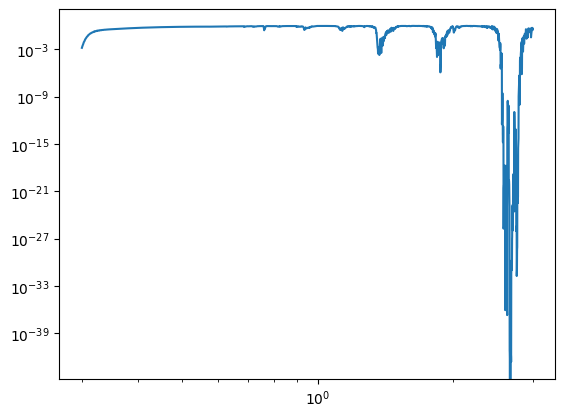

In [65]:
df.interpolate(method="linear")["7.5_1.9"].plot(loglog=True)

In [ ]:
df = df.interpolate(method="linear")
df.to_pickle("./datafiles/pre_grid_03_to_3_microns_2400m_" + sky_type + ".pkl")

[2.09]


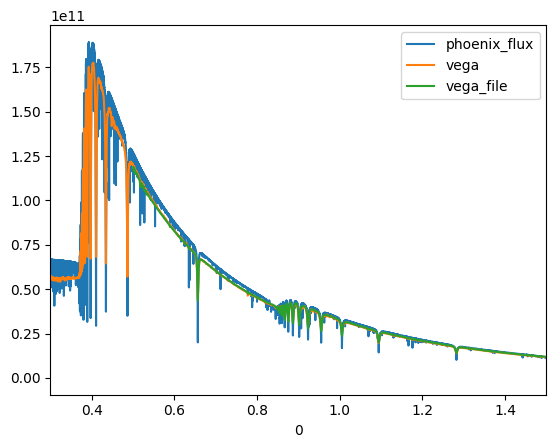

In [68]:
Rsun = 6.96342e8  # [m]
h = 6.62607004e-34
c = 299792458
pc = 3.0857e16

fig, ax = plt.subplots()

rootdir = "./datafiles/stellar_spectra_2/"
file = "9700K.csv"
R = stellarProps[stellarProps["Teff"] == int(str(file[:-5]))]["R_Rsun"].values * Rsun
print(R / Rsun)
R = 2.726 * Rsun
pd.read_csv(rootdir + str(file), index_col=0).apply(
    lambda x: x * R**2 * (x.index * 1e-6) / (h * c * (7.68 * pc) ** 2)
).plot(
    ax=ax
)  # photon/s/m2/um

sp = S.Vega
sp.convert("photlam")  # photon/s/cm^2/A
sp.convert("Micron")

df = pd.DataFrame({"vega": sp.flux * 1e4 * 1e4}, index=sp.wave)  # photon/s/m2/um
df.plot(ax=ax)

vega = pd.read_csv("./datafiles/vega.csv", header=None, index_col=0)
vega = vega[1].rename("vega_file")
vega.plot(ax=ax)

ax.set_xlim(0.3, 1.5)
ax.legend()

In [70]:
sp = S.Vega
sp.convert("photlam")  # photon/s/cm^2/A
sp.convert("Micron")

df = pd.DataFrame({"vega": sp.flux * 1e4 * 1e4}, index=sp.wave)  # photon/s/m2/um
df.plot(ax=ax)

df_inp = interpolate_dfs(wavelengths, df)

# df_inp
df_inp.to_csv("./datafiles/vega_03_to_3_microns.csv")